In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/forest_classification/cover_data.csv')

In [ ]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

outlier detecting


In [ ]:
import numpy as np
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [ ]:
for column in df.columns:
  print(f'for column {column}, the number of outlier_count is: {outlier_function(df, column)[2]} ')
#since wilderness area and soil type columns are one-hot encoded, we can focus on the rest:
# slope, 
#horizontal_distance_to_hydrology,
#vertical_distance_to_hydrology,
#hillshade_9am,
#hillshade_noon,
#horizontal_distance_to_fire_points


for column Elevation, the number of outlier_count is: 0 
for column Aspect, the number of outlier_count is: 0 
for column Slope, the number of outlier_count is: 275 
for column Horizontal_Distance_To_Hydrology, the number of outlier_count is: 414 
for column Vertical_Distance_To_Hydrology, the number of outlier_count is: 5339 
for column Horizontal_Distance_To_Roadways, the number of outlier_count is: 0 
for column Hillshade_9am, the number of outlier_count is: 1027 
for column Hillshade_Noon, the number of outlier_count is: 1191 
for column Hillshade_3pm, the number of outlier_count is: 0 
for column Horizontal_Distance_To_Fire_Points, the number of outlier_count is: 10 
for column Wilderness_Area1, the number of outlier_count is: 0 
for column Wilderness_Area2, the number of outlier_count is: 29884 
for column Wilderness_Area3, the number of outlier_count is: 0 
for column Wilderness_Area4, the number of outlier_count is: 36968 
for column Soil_Type1, the number of outlier_count is: 

In [ ]:
features_to_clean_outliers = ['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Hillshade_9am','Hillshade_Noon','Horizontal_Distance_To_Fire_Points' ]
for feature in features_to_clean_outliers:
  df = df[(df[feature] > outlier_function(df, feature)[0]) & (df[feature] < outlier_function(df, feature)[1])] 

Exploratory Data Analysis (EDA)

start with looking at the target(class), and then focus on the relationships between other features and the class


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


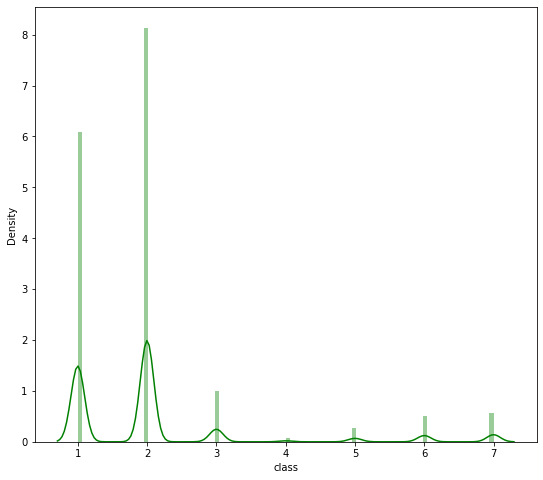

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 8))
sns.distplot(df['class'], color='g', bins=100, hist_kws={'alpha': 0.4});

To have a look at this relationship, wilderness area columns will be reverse-one-hot-encoded

In [ ]:
df['Wilderness_Area_Type'] = (df.iloc[:, 11:15] == 1).idxmax(1)
df = df.drop(columns=['Wilderness_Area1', 'Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 572833 entries, 0 to 581011
Data columns (total 52 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Elevation                           572833 non-null  int64 
 1   Aspect                              572833 non-null  int64 
 2   Slope                               572833 non-null  int64 
 3   Horizontal_Distance_To_Hydrology    572833 non-null  int64 
 4   Vertical_Distance_To_Hydrology      572833 non-null  int64 
 5   Horizontal_Distance_To_Roadways     572833 non-null  int64 
 6   Hillshade_9am                       572833 non-null  int64 
 7   Hillshade_Noon                      572833 non-null  int64 
 8   Hillshade_3pm                       572833 non-null  int64 
 9   Horizontal_Distance_To_Fire_Points  572833 non-null  int64 
 10  Soil_Type1                          572833 non-null  int64 
 11  Soil_Type2                          572

reverse-one-hot-encoded on soil-type


In [ ]:
df['Soil_Type'] = (df.iloc[:, 10:49] == 1).idxmax(1)
for i in range(1, 41):
  df = df.drop(columns=['Soil_Type' + str(i)])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 572833 entries, 0 to 581011
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Elevation                           572833 non-null  int64 
 1   Aspect                              572833 non-null  int64 
 2   Slope                               572833 non-null  int64 
 3   Horizontal_Distance_To_Hydrology    572833 non-null  int64 
 4   Vertical_Distance_To_Hydrology      572833 non-null  int64 
 5   Horizontal_Distance_To_Roadways     572833 non-null  int64 
 6   Hillshade_9am                       572833 non-null  int64 
 7   Hillshade_Noon                      572833 non-null  int64 
 8   Hillshade_3pm                       572833 non-null  int64 
 9   Horizontal_Distance_To_Fire_Points  572833 non-null  int64 
 10  class                               572833 non-null  int64 
 11  Wilderness_Area_Type                572

change the object features to labelorder features

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Soil_Type'] = label_encoder.fit_transform(df['Soil_Type'])
df['Wilderness_Area_Type'] = label_encoder.fit_transform(df['Wilderness_Area_Type'])

In [ ]:
print(df['class'])

0         5
1         5
2         2
3         2
4         5
         ..
581007    3
581008    3
581009    3
581010    3
581011    3
Name: class, Length: 572833, dtype: int64


In [ ]:
#drop the column of class and then add it, so it can be staying in the last
df_class = df['class']
df = df.drop('class',axis = 1)
df.insert(12, 'class', df_class)

In [ ]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Type,Soil_Type,class
0,2596,51,3,258,0,510,221,232,148,6279,0,21,5
1,2590,56,2,212,-6,390,220,235,151,6225,0,21,5
2,2804,139,9,268,65,3180,234,238,135,6121,0,3,2
3,2785,155,18,242,118,3090,238,238,122,6211,0,23,2
4,2595,45,2,153,-1,391,220,234,150,6172,0,21,5


plot the distribution of some features

count    572833.000000
mean       2958.783111
std         277.223013
min        1859.000000
25%        2809.000000
50%        2995.000000
75%        3163.000000
max        3858.000000
Name: Elevation, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


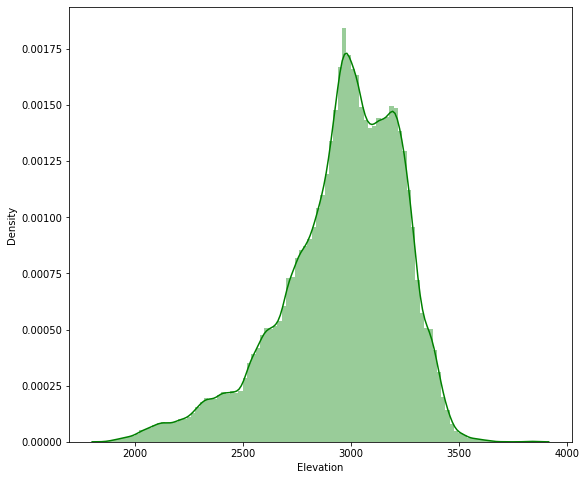

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
print(df['Elevation'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['Elevation'], color='g', bins=100, hist_kws={'alpha': 0.4});

list the numeric columns

In [ ]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Type,Soil_Type,class
0,2596,51,3,258,0,510,221,232,148,6279,0,21,5
1,2590,56,2,212,-6,390,220,235,151,6225,0,21,5
2,2804,139,9,268,65,3180,234,238,135,6121,0,3,2
3,2785,155,18,242,118,3090,238,238,122,6211,0,23,2
4,2595,45,2,153,-1,391,220,234,150,6172,0,21,5


show the hist distribution of some features

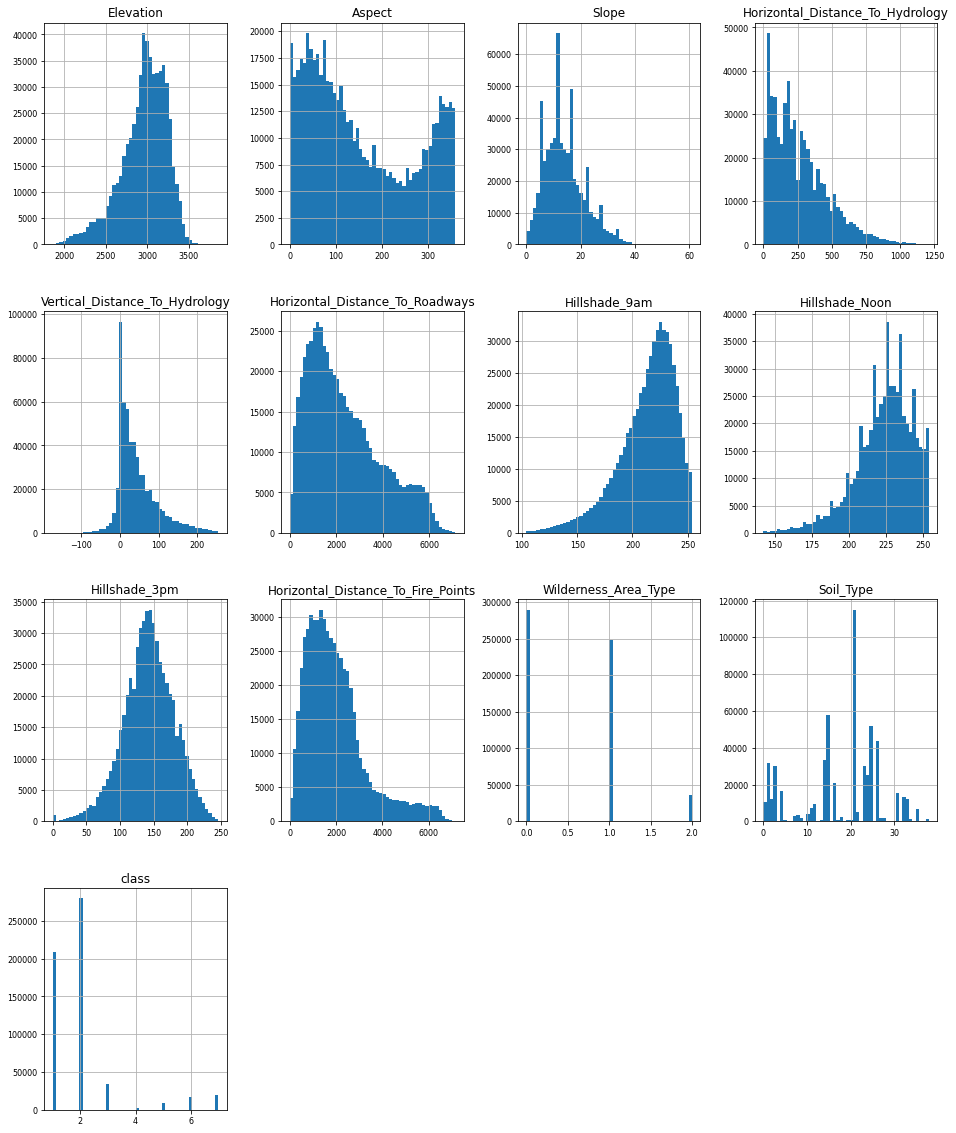

In [ ]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [ ]:
df_num_corr = df_num.corr()['class'][:-1]
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Class:\n{}".format(len(golden_features_list), golden_features_list))
print(df_num_corr)

There is 0 strongly correlated values with Class:
Series([], Name: class, dtype: float64)
Elevation                            -0.280910
Aspect                                0.016839
Slope                                 0.150264
Horizontal_Distance_To_Hydrology     -0.031917
Vertical_Distance_To_Hydrology        0.078395
Horizontal_Distance_To_Roadways      -0.160281
Hillshade_9am                        -0.032928
Hillshade_Noon                       -0.093518
Hillshade_3pm                        -0.048707
Horizontal_Distance_To_Fire_Points   -0.111925
Wilderness_Area_Type                  0.311326
Soil_Type                            -0.055426
Name: class, dtype: float64


relationship between each pair of features(take a lot of time)

In [ ]:
"""
g = sns.PairGrid(df_num)
g.map(sns.scatterplot)
"""

'\ng = sns.PairGrid(df_num)\ng.map(sns.scatterplot)\n'

not plot the relationship between each pair of features, just compare the value of correlations of each pair

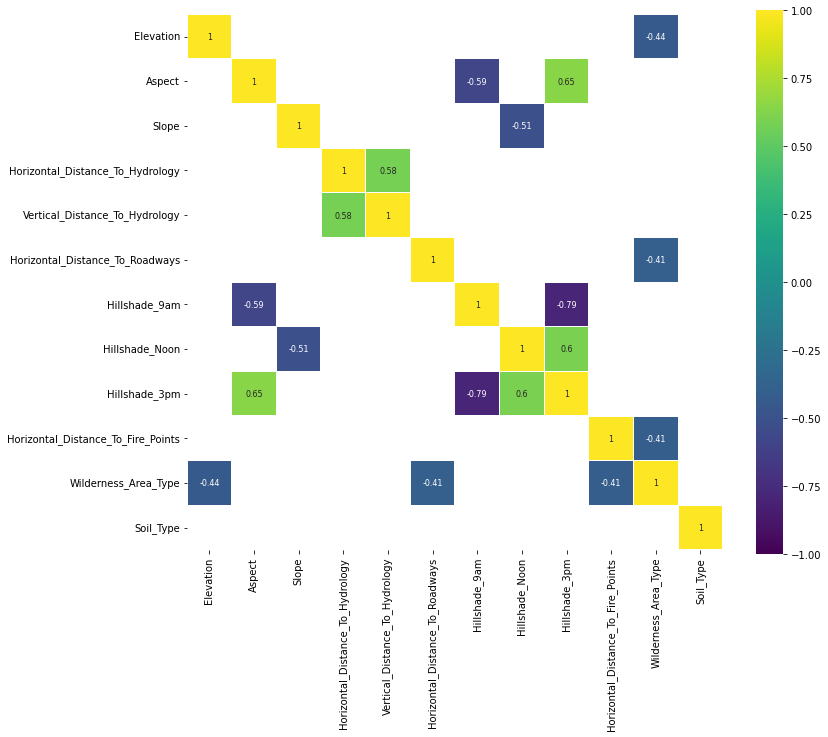

In [ ]:
corr = df_num.drop('class', axis=1).corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

relationship between continual features and class

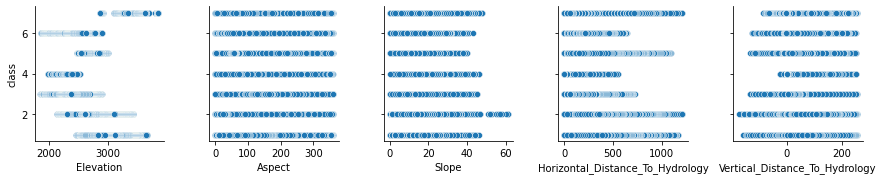

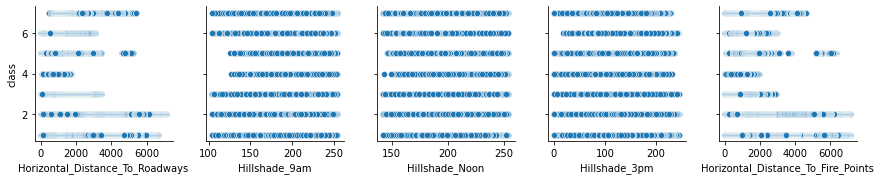

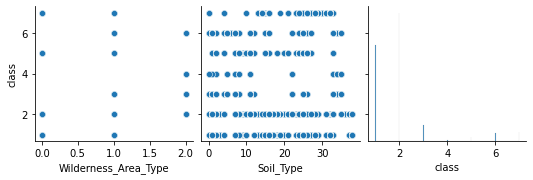

In [ ]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['class'])

In [ ]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Type,Soil_Type,class
0,2596,51,3,258,0,510,221,232,148,6279,0,21,5
1,2590,56,2,212,-6,390,220,235,151,6225,0,21,5
2,2804,139,9,268,65,3180,234,238,135,6121,0,3,2
3,2785,155,18,242,118,3090,238,238,122,6211,0,23,2
4,2595,45,2,153,-1,391,220,234,150,6172,0,21,5


distribution of categorical features

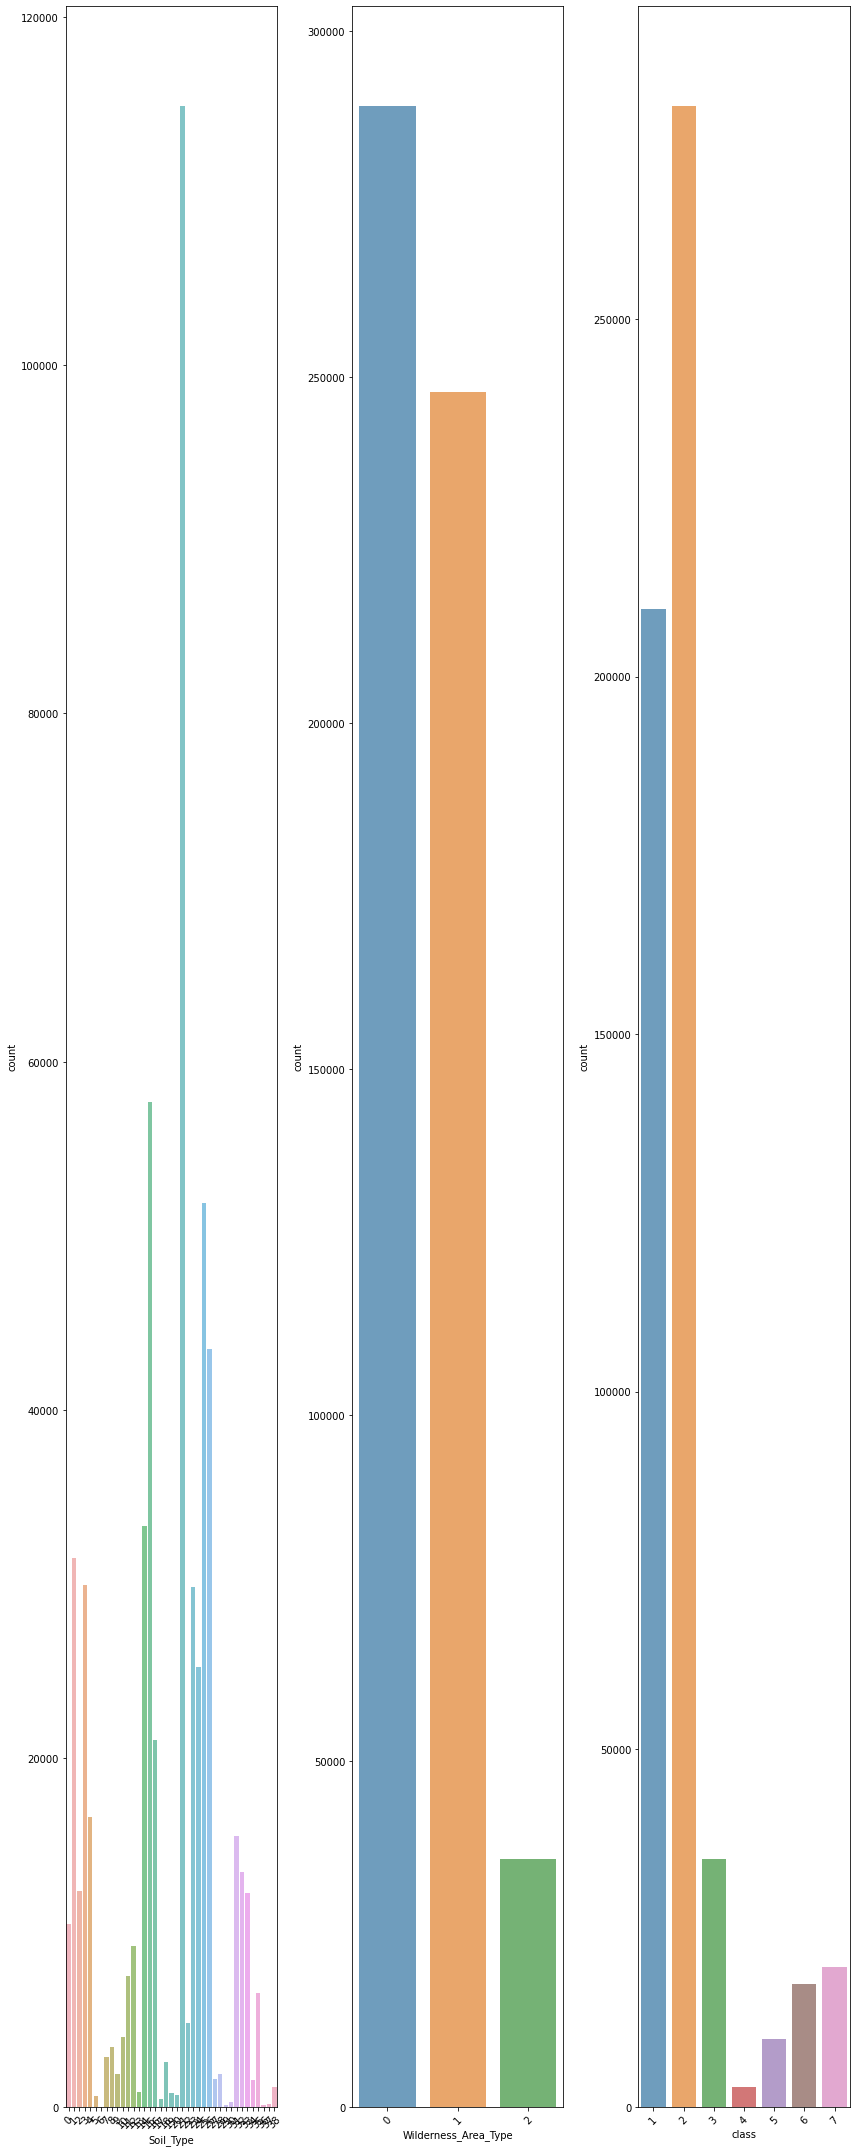

In [ ]:
df_not_num= df[['Soil_Type', 'Wilderness_Area_Type', 'class']]
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text major ticklabel objects>)

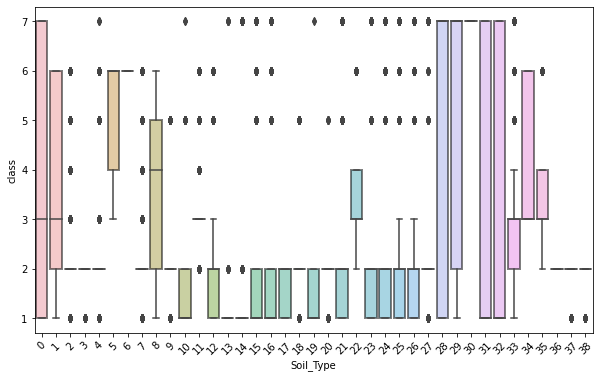

In [ ]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Soil_Type', y='class', data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

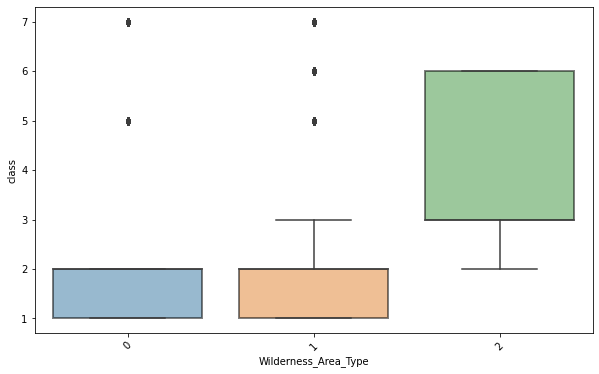

In [ ]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Wilderness_Area_Type', y='class', data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

relationship between categorical features and class

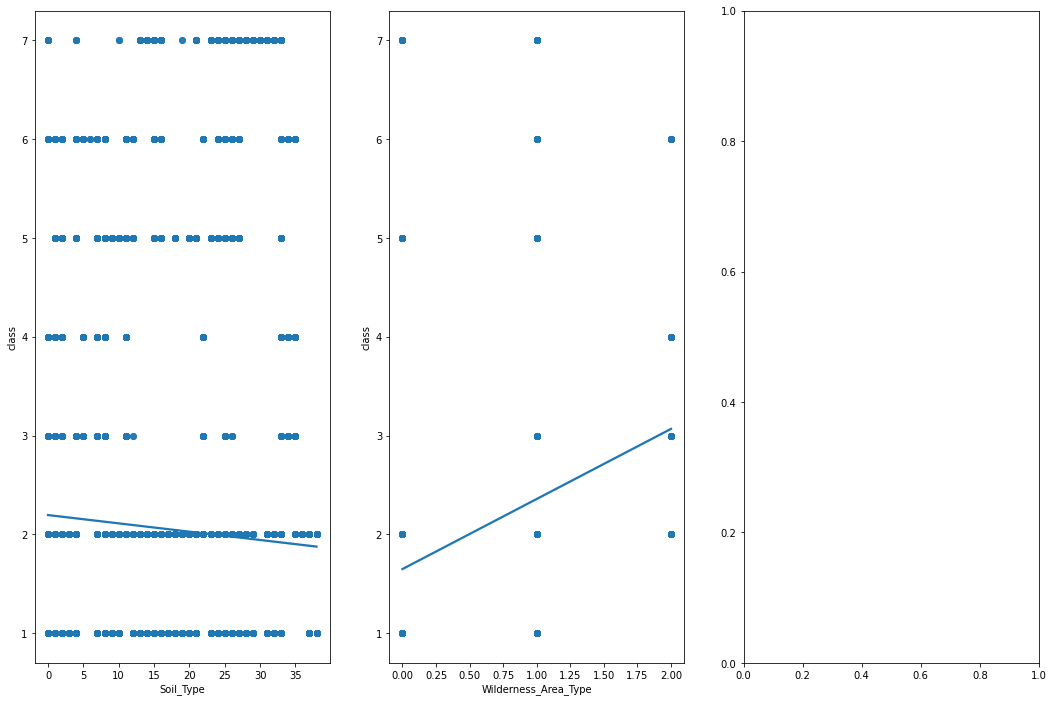

In [ ]:
features_to_analyse = ['Soil_Type', 'Wilderness_Area_Type', 'class']
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y='class', data=df[features_to_analyse], ax=ax)

split data into train, validation and test

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import numpy as np


In [ ]:
#split the data to train and test set
y = df['class']
x = df.iloc[:,:-1]
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.32, random_state = 0)
X_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,class,Wilderness_Area_Type
206334,3299,342,3,330,34,5733,213,235,159,589,1,0
295863,2419,292,23,297,13,1050,149,228,216,67,6,2
145600,3208,354,10,690,115,2828,204,223,157,3672,1,0
522785,2921,225,24,127,30,3027,180,254,202,2073,2,1
147822,2909,175,14,450,77,2940,227,247,149,2010,2,0


In [ ]:
#scale the numeric features
features_to_scale = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways','Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
ct = ColumnTransformer([('numeric', StandardScaler(),['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time'])])
#fit: calculate the mean, sigma and other things
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

ValueError: ignored

In [ ]:
import os
os.chdir("drive/Colab Notebooks")